In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import chardet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error,accuracy_score, classification_report
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler



# **1.Load dataset**

In [4]:
df = pd.read_csv("TRI_CO2_estimates.csv")
print(df.head())

   YEAR                       FACILITY_NAME        CHEMICAL  \
0  2023          TESORO EAST HYNES TERMINAL        n-Hexane   
1  2023                           TEPRO INC         Toluene   
2  2023  VERDANT SPECIALTY SOLUTIONS US LLC  Diethanolamine   
3  2023                   SMO BARSTOW PLANT    Ethylbenzene   
4  2023                    VEOLIA N.A. INC.     Cyclohexane   

            INDUSTRY_SECTOR      CAS#  Mass_Released_kg   LATITUDE  \
0  Petroleum Bulk Terminals  110-54-3            844.00  33.862483   
1       Plastics and Rubber  108-88-3             23.00  35.195660   
2                 Chemicals  111-42-2              0.00  41.443056   
3                     Other  100-41-4              0.00  38.512210   
4           Hazardous Waste  110-82-7              6.05  38.598032   

    LONGITUDE  Carbon_Fraction       CO2_kg  
0 -118.159907            83.62  2587.760267  
1  -86.083770            91.25    76.954167  
2  -87.737500            45.70     0.000000  
3  -76.644280   

# **2.ML methods and analyse**

In [30]:
print("Number of unique sectors:", df["INDUSTRY_SECTOR"].nunique())
sector_counts = df["INDUSTRY_SECTOR"].value_counts()
print(sector_counts)

Number of unique sectors: 29
INDUSTRY_SECTOR
Chemicals                            16701
Petroleum                             4787
Petroleum Bulk Terminals              4751
Chemical Wholesalers                  2805
Hazardous Waste                       2335
Transportation Equipment              2027
Natural Gas Processing                1491
Fabricated Metals                     1402
Plastics and Rubber                   1333
Paper                                 1153
Food                                  1091
Nonmetallic Mineral Product            934
Other                                  831
Primary Metals                         801
Electric Utilities                     571
Wood Products                          534
Machinery                              505
Miscellaneous Manufacturing            337
Computers and Electronic Products      289
Furniture                              280
Electrical Equipment                   222
Textiles                               165
Printing 

R² = 0.8698
Regression equation: CO₂ = 1.648 * Mass + 6574.382


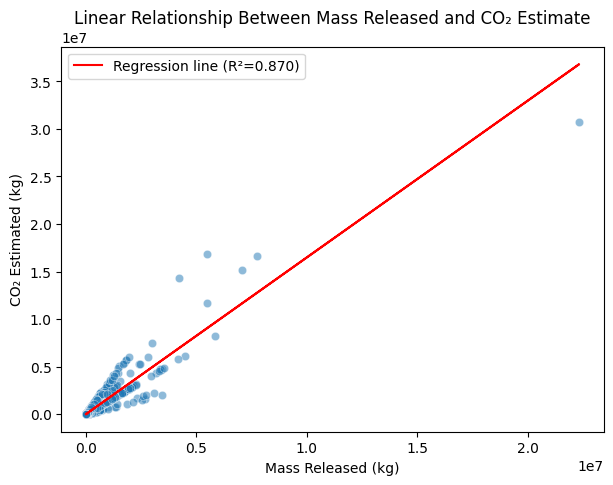

In [5]:
# --- Linear Regression (Mass vs CO₂) ---
X = df[['Mass_Released_kg']]
y = df['CO2_kg']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"R² = {r2:.4f}")
print("Regression equation: CO₂ = %.3f * Mass + %.3f" % (model.coef_[0], model.intercept_))

plt.figure(figsize=(7,5))
sns.scatterplot(x='Mass_Released_kg', y='CO2_kg', data=df, alpha=0.5)
plt.plot(df['Mass_Released_kg'], y_pred, color='red', label=f'Regression line (R²={r2:.3f})')
plt.title("Linear Relationship Between Mass Released and CO₂ Estimate")
plt.xlabel("Mass Released (kg)")
plt.ylabel("CO₂ Estimated (kg)")
plt.legend()
plt.show()

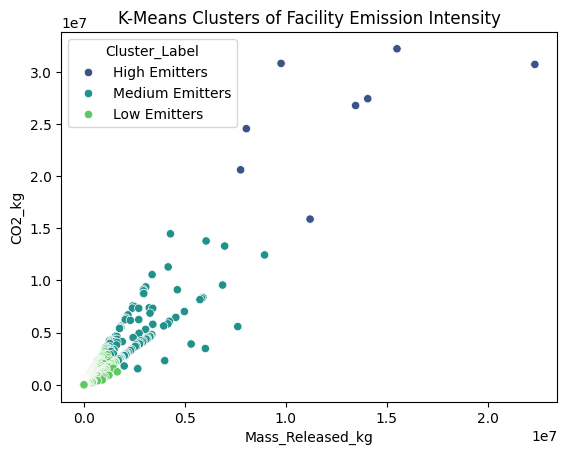

Clustered results saved → CO2_facility_clusters.csv


In [7]:
grouped = (
    df.groupby("FACILITY_NAME")[["Mass_Released_kg","CO2_kg"]]
    .sum().reset_index().sort_values("CO2_kg", ascending=False)
)
X = grouped[["Mass_Released_kg","CO2_kg"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
grouped["Cluster"] = kmeans.fit_predict(X_scaled)

cluster_labels = {0:"Low Emitters",1:"Medium Emitters",2:"High Emitters"}
grouped["Cluster_Label"] = grouped["Cluster"].map(cluster_labels)

sns.scatterplot(x="Mass_Released_kg", y="CO2_kg",
                hue="Cluster_Label", data=grouped, palette="viridis")
plt.title("K-Means Clusters of Facility Emission Intensity")
plt.show()

grouped.to_csv("CO2_facility_clusters.csv", index=False)
print("Clustered results saved → CO2_facility_clusters.csv")


# **Predictions using knn**

In [23]:

X = df[["CO2_kg", "Mass_Released_kg", "Carbon_Fraction"]]
y = df["YEAR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.515927750410509
              precision    recall  f1-score   support

        2013       0.52      0.52      0.52      4613
        2023       0.51      0.52      0.51      4522

    accuracy                           0.52      9135
   macro avg       0.52      0.52      0.52      9135
weighted avg       0.52      0.52      0.52      9135



Trained a model to predict the industry secotor

In [28]:

X = df[["CO2_kg", "Mass_Released_kg", "Carbon_Fraction"]]
y = df["INDUSTRY_SECTOR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



knn = KNeighborsClassifier(n_neighbors=34)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.39562123700054735


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                   precision    recall  f1-score   support

                        Beverages       0.00      0.00      0.00         8
             Chemical Wholesalers       0.22      0.13      0.17       595
                        Chemicals       0.43      0.79      0.56      3360
                      Coal Mining       0.00      0.00      0.00         1
Computers and Electronic Products       0.00      0.00      0.00        62
               Electric Utilities       0.35      0.17      0.23       106
             Electrical Equipment       0.00      0.00      0.00        42
                Fabricated Metals       0.17      0.00      0.01       296
                             Food       0.69      0.26      0.38       238
                        Furniture       0.00      0.00      0.00        61
                  Hazardous Waste       0.29      0.07      0.11       437
                          Leather       0.00      0.00      0.00         3
                        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In this section, the dataset is analyzed to understand how total CO₂ emissions have changed across different industry sectors between 2013 and 2023.First, emissions are grouped by industry sector and year, and the total CO₂ emitted in each category is calculated. This produces a sector–year breakdown that allows direct comparison between the two years.

A pivot table is then created where each row represents an industry sector and the columns show its CO₂ emissions for 2013 and 2023. An additional column, Change_kg, computes the difference (2023 minus 2013), indicating which sectors increased or decreased their emissions over the decade.

In [25]:
sector_year = (
    df.groupby(["INDUSTRY_SECTOR", "YEAR"])["CO2_kg"]
    .sum()
    .reset_index()
)

print(sector_year.head())

pivot_df = sector_year.pivot(index="INDUSTRY_SECTOR", columns="YEAR", values="CO2_kg").fillna(0)
pivot_df["Change_kg"] = pivot_df[2023] - pivot_df[2013]

print(pivot_df.head())


        INDUSTRY_SECTOR  YEAR        CO2_kg
0             Beverages  2013  1.060308e+05
1             Beverages  2023  3.335778e+05
2  Chemical Wholesalers  2013  1.780122e+06
3  Chemical Wholesalers  2023  1.252651e+07
4             Chemicals  2013  3.111538e+08
YEAR                                       2013          2023     Change_kg
INDUSTRY_SECTOR                                                            
Beverages                          1.060308e+05  3.335778e+05  2.275470e+05
Chemical Wholesalers               1.780122e+06  1.252651e+07  1.074639e+07
Chemicals                          3.111538e+08  2.483067e+08 -6.284706e+07
Coal Mining                        0.000000e+00  3.327427e+02  3.327427e+02
Computers and Electronic Products  2.222155e+06  1.515489e+06 -7.066665e+05


Two visualisations are generated,Total Emissions by Sector for Each Year and Change Plot of  Net Emission Difference per Sector

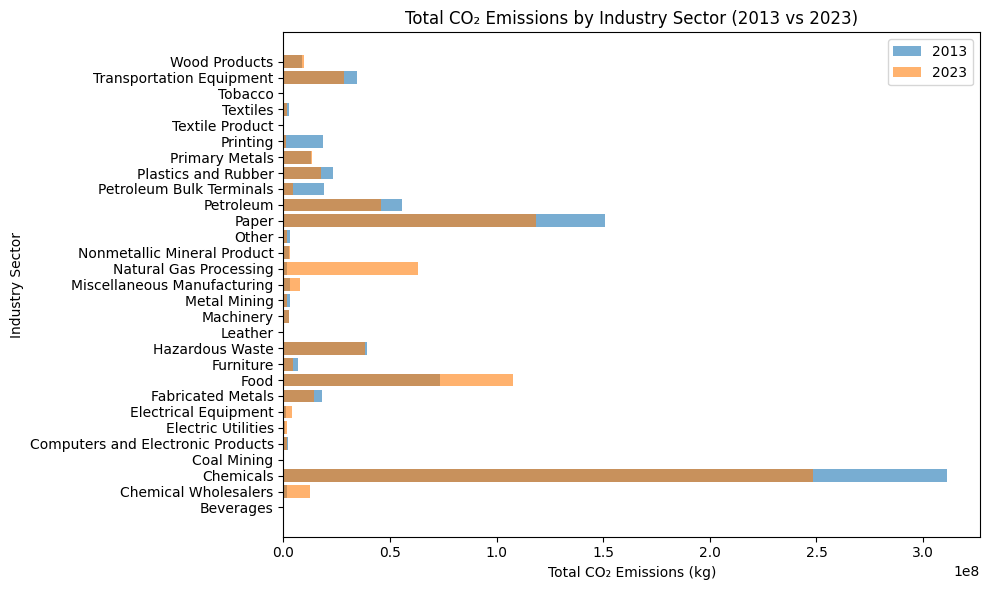

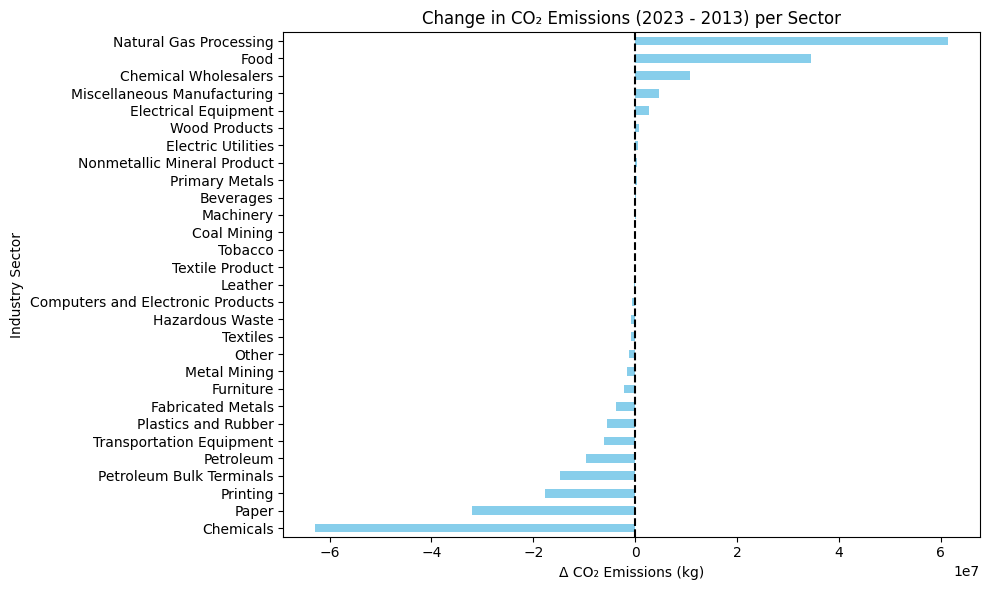

In [27]:

plt.figure(figsize=(10, 6))
for year in [2013, 2023]:
    plt.barh(
        pivot_df.index,
        pivot_df[year],
        alpha=0.6,
        label=str(year)
    )

plt.xlabel("Total CO₂ Emissions (kg)")
plt.ylabel("Industry Sector")
plt.title("Total CO₂ Emissions by Industry Sector (2013 vs 2023)")
plt.legend()
plt.tight_layout()
plt.show()

pivot_df["Change_kg"].sort_values().plot(kind="barh", figsize=(10,6), color="skyblue")
plt.title("Change in CO₂ Emissions (2023 - 2013) per Sector")
plt.xlabel("Δ CO₂ Emissions (kg)")
plt.ylabel("Industry Sector")
plt.axvline(0, color="black", linestyle="--")
plt.tight_layout()
plt.show()

#Bars to the right of zero → increase in emissions

#Bars to the left → reduction in emissions



Model for predicting sector improved when data was standardized

In [22]:
#predict industry sector included scaling improved by almost 10 percent

#Improving model based on anayleses -including more features ..
# df5_encoded = pd.get_dummies(df5, columns=["INDUSTRY_SECTOR"], drop_first=True)
# X = df5_encoded.drop(columns=["YEAR", "FACILITY_NAME", "CHEMICAL", "CAS#"])
# y = df5_encoded["YEAR"]


X = df[["Mass_Released_kg", "Carbon_Fraction", "CO2_kg"]]  # predictors
y = df["INDUSTRY_SECTOR"]  # target


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


knn = KNeighborsClassifier(n_neighbors=34)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.4372035320732686


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                   precision    recall  f1-score   support

                        Beverages       0.00      0.00      0.00        11
             Chemical Wholesalers       0.19      0.12      0.15       853
                        Chemicals       0.47      0.76      0.58      5033
                      Coal Mining       0.00      0.00      0.00         1
Computers and Electronic Products       0.26      0.07      0.11        84
               Electric Utilities       0.31      0.21      0.25       151
             Electrical Equipment       0.10      0.01      0.03        69
                Fabricated Metals       0.43      0.13      0.20       430
                             Food       0.71      0.51      0.60       342
                        Furniture       0.18      0.03      0.06        87
                  Hazardous Waste       0.40      0.09      0.15       690
                          Leather       0.00      0.00      0.00         4
                        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
